In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf

In [2]:
base_dir = './input/dataset/'

# 关闭execution防止报错
tf.compat.v1.disable_eager_execution()

# 归一化处理
def process_image(image):
    return image / 255.

def load_data(path):
    high_res_images = []
    low_res_images = []
    for dirname, _, filenames in os.walk(path + 'low_res'):
        for filename in filenames:
            img = cv2.imread(os.path.join(dirname, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = process_image(img)
            low_res_images.append(img)

    for dirname, _, filenames in os.walk(path + 'high_res'):
        for filename in filenames:
            img = cv2.imread(os.path.join(dirname, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = process_image(img)
            high_res_images.append(img)

    return np.array(low_res_images), np.array(high_res_images)

In [3]:
train_x, train_y = load_data(base_dir + 'train/')
val_x, val_y = load_data(base_dir + 'val/')

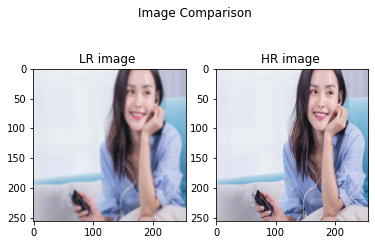

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Image Comparison')
ax1.imshow(train_x[615])
ax1.title.set_text("LR image ")
ax2.imshow(train_y[615])
ax2.title.set_text("HR image ")
plt.show()

In [5]:
# 残差
def residual_block_gen(ch=64,k_s=3,st=1):
    model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),])
    return model


input_img=Input(shape=(256,256,3))
l1=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(input_img)
l2=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l1)
l3=MaxPooling2D(padding='same')(l2)
l4=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l3)
l5=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l4)
l6=MaxPooling2D(padding='same')(l5)

l7=Conv2D (256,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l6)
l7=residual_block_gen()(l7)
l8=UpSampling2D()(l7)
l9=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l8)
l10=Conv2D (128,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l9)
l11=add([l10,l5])
l12=UpSampling2D()(l11)
l13=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l12)
l14=Conv2D (64,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l13)
l15=add([l14,l2])

decoder=Conv2D (3,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(l15)
#out= tf.keras.filters
autoencoder_residual=Model(input_img,decoder)
autoencoder_residual.summary()
#plot_model(autoencoder_residual, to_file ='encoder.png',show_shapes=True)

Instructions for updating:
Colocations handled automatically by placer.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________

In [6]:
autoencoder_residual.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

epochs=15
history=autoencoder_residual.fit(train_x, train_y,
        epochs = epochs, batch_size = 8,validation_data = (val_x, val_y))


Train on 685 samples, validate on 170 samples
Epoch 1/15
685/685 [==============================] - ETA: 0s - loss: 0.0742 - acc: 0.6546

d:\python\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


685/685 [==============================] - 25s 36ms/sample - loss: 0.0742 - acc: 0.6546 - val_loss: 0.0482 - val_acc: 0.4753
Epoch 2/15
685/685 [==============================] - 18s 26ms/sample - loss: 0.0296 - acc: 0.7812 - val_loss: 0.0272 - val_acc: 0.7897
Epoch 3/15
685/685 [==============================] - 18s 26ms/sample - loss: 0.0258 - acc: 0.8003 - val_loss: 0.0241 - val_acc: 0.8355
Epoch 4/15
685/685 [==============================] - 18s 26ms/sample - loss: 0.0257 - acc: 0.7897 - val_loss: 0.0277 - val_acc: 0.7843
Epoch 5/15
685/685 [==============================] - 18s 26ms/sample - loss: 0.0244 - acc: 0.8014 - val_loss: 0.0213 - val_acc: 0.7999
Epoch 6/15
685/685 [==============================] - 18s 26ms/sample - loss: 0.0230 - acc: 0.8122 - val_loss: 0.0207 - val_acc: 0.8472
Epoch 7/15
685/685 [==============================] - 18s 26ms/sample - loss: 0.0220 - acc: 0.8293 - val_loss: 0.0202 - val_acc: 0.8408
Epoch 8/15
685/685 [==============================] - 18s 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


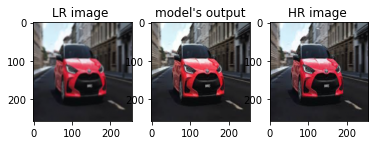

In [7]:
predict_y = autoencoder_residual.predict(val_x)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(val_x[3])
ax1.title.set_text("LR image ")

ax2.imshow(predict_y[3])
ax2.title.set_text("model's output")

ax3.imshow(val_y[3])
ax3.title.set_text("HR image ")
plt.show()

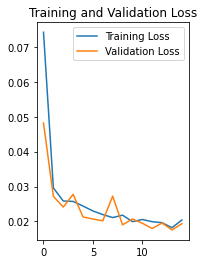

In [9]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


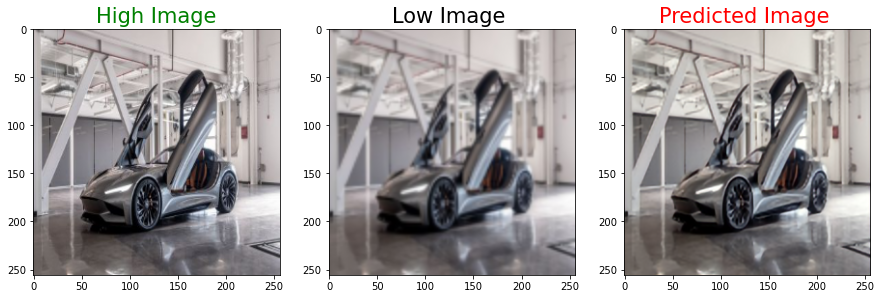

C:\Users\lenovo\AppData\Local\Temp/ipykernel_18772/2757235926.py:19: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr = compare_psnr(hr, pre)
d:\python\lib\site-packages\skimage\metrics\_structural_similarity.py:107: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[..., ch],
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


原图和输出图像比较后，PSNR：30.122091831845136，SSIM：0.9583053416037656


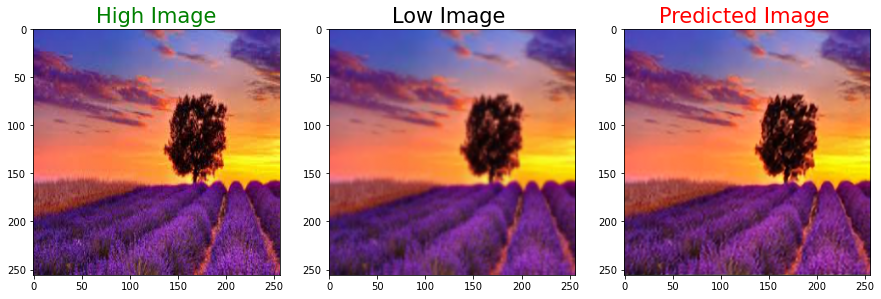

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


原图和输出图像比较后，PSNR：30.352020091791083，SSIM：0.9477080843201406


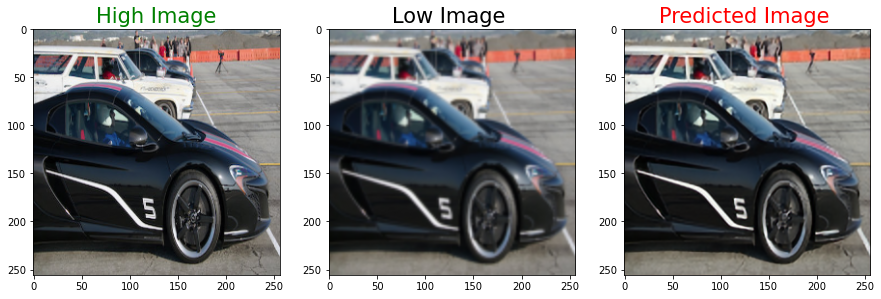

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


原图和输出图像比较后，PSNR：29.11910908276498，SSIM：0.9481524560139674


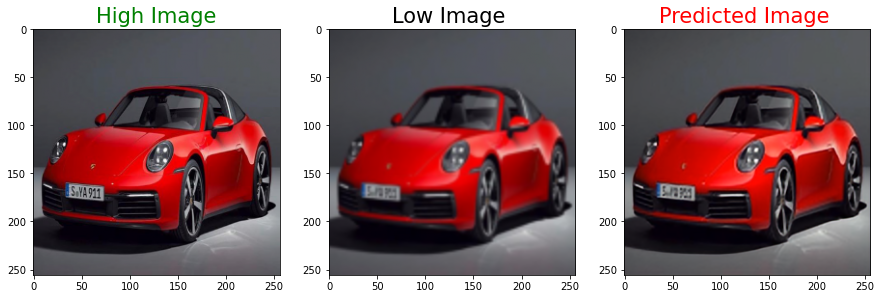

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


原图和输出图像比较后，PSNR：30.305179669678438，SSIM：0.9518426295358043


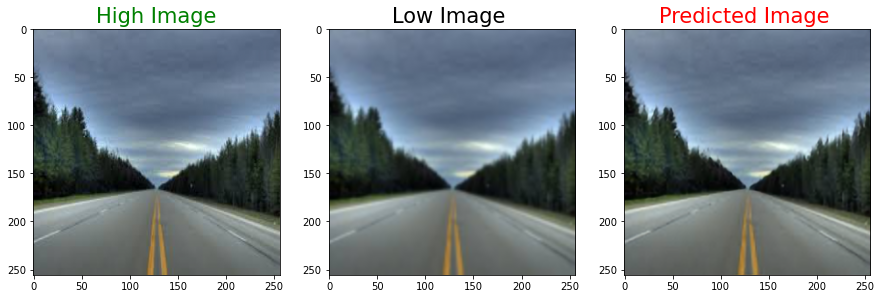

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


原图和输出图像比较后，PSNR：37.12520290564182，SSIM：0.988873739388214


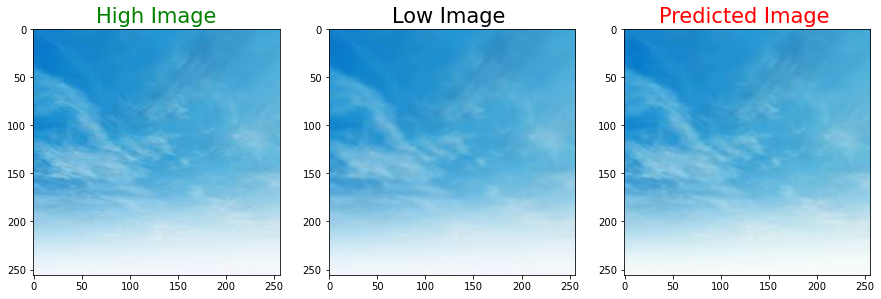

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


原图和输出图像比较后，PSNR：39.03527138490756，SSIM：0.9952843815054228


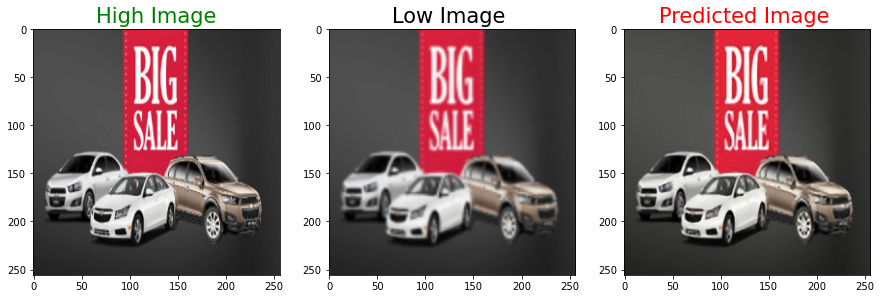

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


原图和输出图像比较后，PSNR：29.416485537525794，SSIM：0.970724219293284


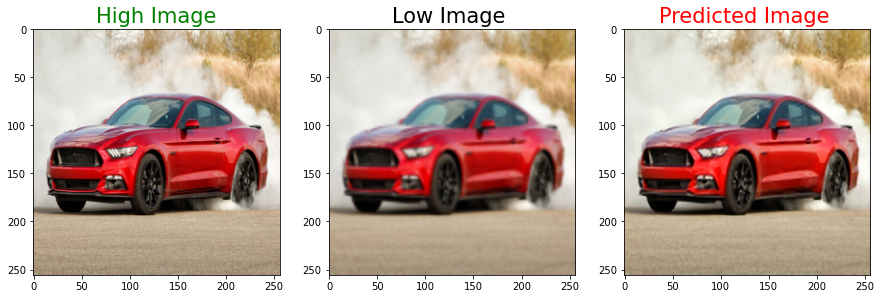

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


原图和输出图像比较后，PSNR：30.183938611138103，SSIM：0.9432575745714233


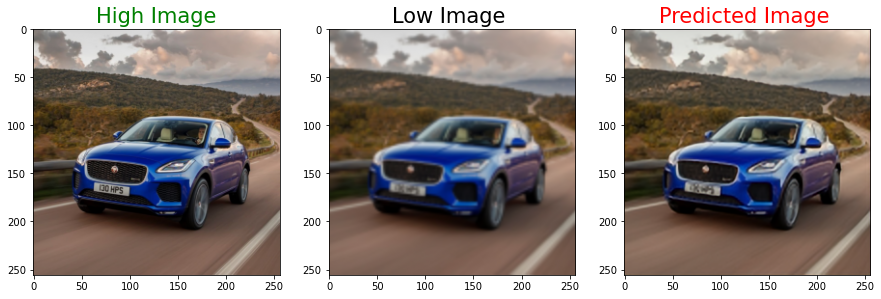

原图和输出图像比较后，PSNR：31.61561591041871，SSIM：0.963504251236735


In [10]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

def plot_images(high, low, predicted):
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('High Image', color='green', fontsize=21)
    plt.imshow(high)
    plt.subplot(1, 3, 2)
    plt.title('Low Image ', color='black', fontsize=21)
    plt.imshow(low)
    plt.subplot(1, 3, 3)
    plt.title('Predicted Image ', color='red', fontsize=21)
    plt.imshow(predicted)

    plt.show()
   
def PSNR_SSIM(hr, pre):
    psnr = compare_psnr(hr, pre)
    ssim = compare_ssim(hr, pre, multichannel=True)  # 对于多通道图像(RGB、HSV等)关键词multichannel要设置为True
    print('原图和输出图像比较后，PSNR：{}，SSIM：{}'.format(psnr, ssim))


for i in range(16, 25):
    #predict_y = np.clip(model.predict(val_x[i].reshape(1,256, 256,3)),0.0,1.0).reshape(256, 256,3)
    plot_images(val_y[i], val_x[i], predict_y[i])
    #print('PSNR', PSNR(val_y[i], predict_y[i]), 'dB')
    PSNR_SSIM(val_y[i],predict_y[i])

In [12]:
autoencoder_residual.save('auto_encoder_res.h5')

d:\python\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
